In [39]:
using Pkg
Pkg.activate("..")
using DrWatson, DataFrames, LinearAlgebra, Plots, Query, StatsPlots
include(srcdir("load.jl"))

Activating environment at `~/dglmoore/yuji/Project.toml`


linearize (generic function with 1 method)

In [3]:
ENV["GKS_WSTYPE"] = "svg";

In [37]:
mi = collect_results(datadir("info", "mi"); verbose=false);

┌ Info: Scanning folder /home/ec2-user/dglmoore/yuji/data/info/mi for result files.
└ @ DrWatson /home/ec2-user/.julia/packages/DrWatson/vLVOx/src/result_collection.jl:79


In [38]:
mi = mi |> @filter(_.gh == 30 && _.gw == 30 && _.lag == 0) |> @select(:drug, :trial, :phase, :lag, :mi) |> DataFrame;

In [40]:
mi[!,:entropy] = diag.(linearize.(mi[:, :mi]));

In [41]:
mi[!,:nondiag] = zerodiag.(linearize.(mi[:,:mi]));

In [42]:
macro infoplot(df, xcol::QuoteNode, ycol::QuoteNode, xlabel::String, ylabel::String,
               legend::Union{QuoteNode,Bool}=:(:topright))
    quote
        kf = $df |> @filter(_.drug == "K-gluconate")
        knf = $df |> @filter(_.drug == "K-gluconate:Nifedipine")
        
        marker=(:circ, 4, 1.0)
        color=[3 4]
        α=0.5

        kplot = @df kf dotplot($xcol, $ycol, group=:phase, marker=marker, color=color, label="")
        @df kf violin!(kplot, $xcol, $ycol, group=:phase, α=α, color=color)

        knplot = @df knf dotplot($xcol, $ycol, group=:phase, marker=marker, color=color, label="")
        @df knf violin!(knplot, $xcol, $ycol, group=:phase, α=α)

        xmin, xmax = extrema($df[:,$xcol])

        plot(kplot, knplot, layout=2, title=["K-gluconate" "K-gluconate + Nifedipine"], titleloc=:left,
             xlabel=$xlabel, xticks=xmin:xmax, ylabel=$ylabel, size=(1000,500), legend=$legend)
    end
end

macro infoplot(xcol::QuoteNode, ycol::QuoteNode, xlabel::String, ylabel::String, legend::Union{QuoteNode,Bool}=:(:topright))
    :(df -> @infoplot df $xcol $ycol $xlabel $ylabel $legend)
end

@infoplot (macro with 4 methods)

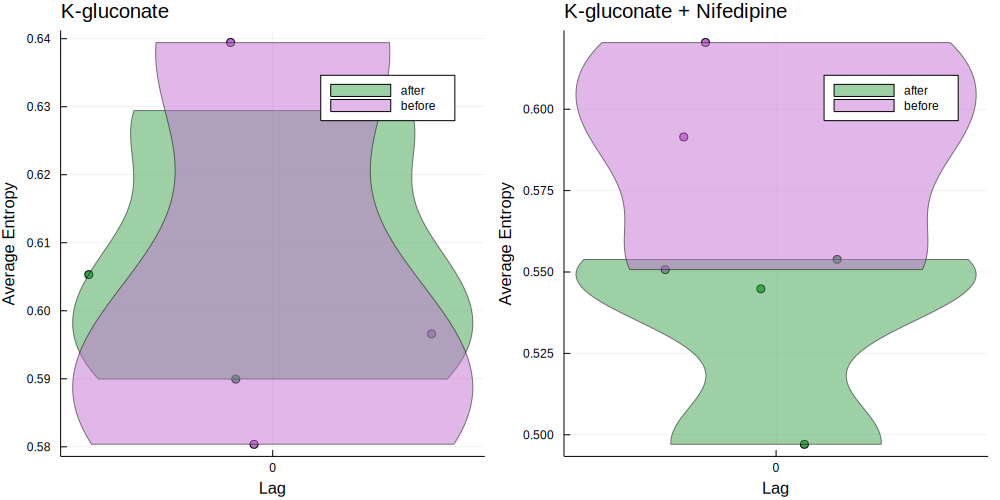

In [45]:
mi |> @map({_.drug, _.trial, _.phase, _.lag, μ=mean(_.entropy)}) |> DataFrame |> @infoplot :lag :μ "Lag" "Average Entropy"

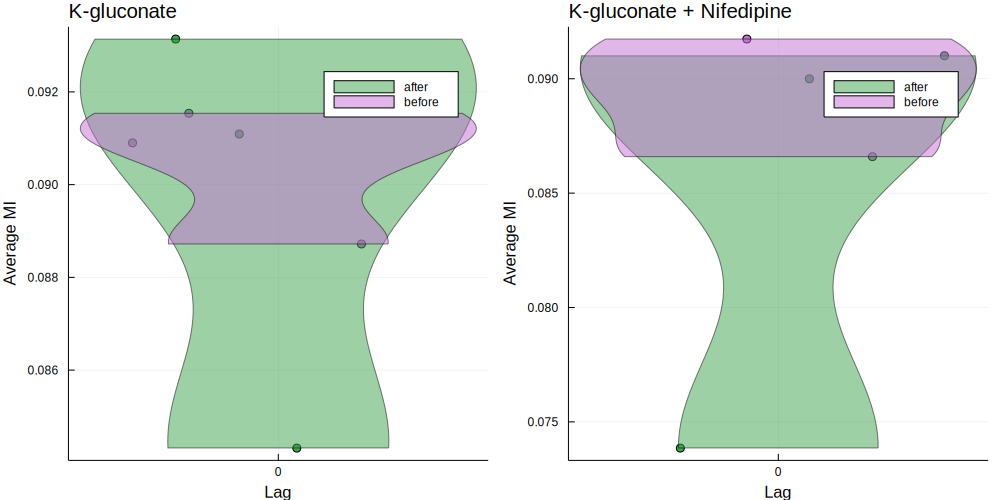

In [48]:
mi |> @map({_.drug, _.trial, _.phase, _.lag, μ=mean(_.nondiag[_.nondiag .!= 0.0])}) |> DataFrame |> @infoplot :lag :μ "Lag" "Average MI"